In [ ]:
from binance.client import Client
from binance.enums import *
from keras.engine import sequential
from keras.layers.recurrent import RNN
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, Dropout, Bidirectional, GRU, ConvLSTM2D, Activation, CuDNNGRU, CuDNNLSTM, Conv2D, Conv1D, Input, MaxPooling1D, \
                         GlobalMaxPooling1D, Embedding
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
                                       EarlyStopping, LearningRateScheduler, \
                                       ReduceLROnPlateau, CSVLogger
from tensorflow.keras.callbacks.experimental import BackupAndRestore
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, \
                                     CategoricalAccuracy, \
                                     SparseCategoricalAccuracy, \
                                     TopKCategoricalAccuracy, \
                                     SparseTopKCategoricalAccuracy

import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import math
import keras
import sys 
import pandas as pd
import numpy as np
import json
import os

# Bidirectional LSTM Layer for Sequence Classification
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.<br>

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem.<br>

It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.<br>

In [ ]:
tf.keras.layers.Bidirectional(
    layer=LSTM, merge_mode="concat", weights=None, backward_layer=None
)

## Arguments
- **layer:** keras.layers.RNN instance, such as keras.layers.LSTM or keras.layers.GRU. It could also be a keras.layers.Layer instance that meets the following criteria:
    1. Be a sequence-processing layer (accepts 3D+ inputs).
    2. Have a go_backwards, return_sequences and return_state attribute (with the same semantics as for the RNN class).
    3. Have an input_spec attribute.
    4. Implement serialization via get_config() and from_config(). Note that the recommended way to create new RNN layers is to write a custom RNN cell and use it with keras.layers.RNN, instead of subclassing keras.layers.Layer directly. - When the returns_sequences is true, the output of the masked timestep will be zero regardless of the layer's original zero_output_for_mask value.
- **merge_mode:** Mode by which outputs of the forward and backward RNNs will be combined. One of {'sum', 'mul', 'concat', 'ave', None}. If None, the outputs will not be combined, they will be returned as a list. Default value is 'concat'.
- **backward_layer:** Optional keras.layers.RNN, or keras.layers.Layer instance to be used to handle backwards input processing. If backward_layer is not provided, the layer instance passed as the layer argument will be used to generate the backward layer automatically. Note that the provided backward_layer layer should have properties matching those of the layer argument, in particular it should have the same values for stateful, return_states, return_sequences, etc. In addition, backward_layer and layer should have different go_backwards argument values. A ValueError will be raised if these requirements are not met.

## Example. Sequence Classification
The problem is defined as a sequence of random values between 0 and 1. This sequence is taken as input for the problem with each number provided one per timestep.<br>

A binary label (0 or 1) is associated with each input. The output values are all 0. Once the cumulative sum of the input values in the sequence exceeds a threshold, then the output value flips from 0 to 1.<br>

A threshold of 1/4 the sequence length is used.<br>

For example, below is a sequence of 10 input timesteps (X):
0.63144003 0.29414551 0.91587952 0.95189228 0.32195638 0.60742236 0.83895793 0.18023048 0.84762691 0.29165514

The corresponding classification output (y) would be:
0 0 0 1 1 1 1 1 1 1

Now let's compare three types of LSTM atchitectures

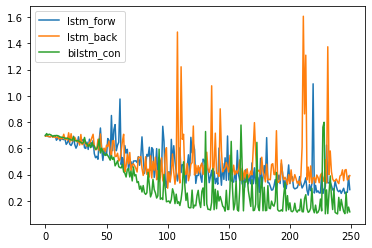

In [2]:
from random import random
from numpy import array
from numpy import cumsum
from matplotlib import pyplot
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
 
# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 1)
	y = y.reshape(1, n_timesteps, 1)
	return X, y
 
def get_lstm_model(n_timesteps, backwards):
	model = Sequential()
	model.add(LSTM(20, input_shape=(n_timesteps, 1), return_sequences=True, go_backwards=backwards))
	model.add(TimeDistributed(Dense(1, activation='sigmoid')))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
def get_bi_lstm_model(n_timesteps, mode):
	model = Sequential()
	model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1), merge_mode=mode))
	model.add(TimeDistributed(Dense(1, activation='sigmoid')))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
def train_model(model, n_timesteps):
	loss = list()
	for _ in range(250):
		# generate new random sequence
		X,y = get_sequence(n_timesteps)
		# fit model for one epoch on this sequence
		hist = model.fit(X, y, epochs=1, batch_size=1, verbose=0)
		loss.append(hist.history['loss'][0])
	return loss
 
 
n_timesteps = 10
results = DataFrame()
# lstm forwards
model = get_lstm_model(n_timesteps, False)
results['lstm_forw'] = train_model(model, n_timesteps)
# lstm backwards
model = get_lstm_model(n_timesteps, True)
results['lstm_back'] = train_model(model, n_timesteps)
# bidirectional concat
model = get_bi_lstm_model(n_timesteps, 'concat')
results['bilstm_con'] = train_model(model, n_timesteps)
# line plot of results
results.plot()
pyplot.show()

### Comparing Bidirectional LSTM Merge Modes

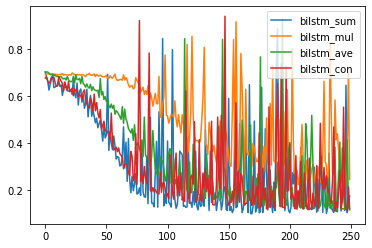

In [3]:
n_timesteps = 10
results = DataFrame()
# sum merge
model = get_bi_lstm_model(n_timesteps, 'sum')
results['bilstm_sum'] = train_model(model, n_timesteps)
# mul merge
model = get_bi_lstm_model(n_timesteps, 'mul')
results['bilstm_mul'] = train_model(model, n_timesteps)
# avg merge
model = get_bi_lstm_model(n_timesteps, 'ave')
results['bilstm_ave'] = train_model(model, n_timesteps)
# concat merge
model = get_bi_lstm_model(n_timesteps, 'concat')
results['bilstm_con'] = train_model(model, n_timesteps)
# line plot of results
results.plot()
pyplot.show()